In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)


# Navigate to the project directory
%cd '/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection/'


# Define dataset path
dataset_path = '/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection/dataset/bonefractureyolo'

Mounted at /content/drive/
/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection


In [2]:
# Install necessary libraries
!pip install -q ultralytics torch torchvision opencv-python pillow matplotlib tqdm
!pip install tabulate

In [3]:
# Import required libraries
import os
import random
import pandas as pd
import numpy as np
import yaml

from sklearn.cluster import KMeans
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from IPython.display import display

from tqdm import tqdm
from ultralytics import YOLO
from collections import Counter  # for counting class distribution

In [4]:
# Set dataset paths
dataset_path = '/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection/dataset/bonefractureyolo'

train_images_dir = os.path.join(dataset_path, 'train/images')
train_labels_dir = os.path.join(dataset_path, 'train/labels')

validation_images_dir = os.path.join(dataset_path, 'valid/images')
validation_labels_dir = os.path.join(dataset_path, 'valid/labels')

test_images_dir = os.path.join(dataset_path, 'test/images')
test_labels_dir = os.path.join(dataset_path, 'test/labels')

In [5]:
#----------------------------------------------------------------------Train Dataset----------------------------------------------------------------

# list comprehensions to create a list for storing train images and labels respectively
train_image_files = sorted([f for f in os.listdir(train_images_dir) if f.endswith('.jpg' )])
train_label_files = sorted([f for f in os.listdir(train_labels_dir) if f.endswith('.txt')])


# Check if the number of images and labels match, ensure neither are empty, and verify consistency between image-label pairs.

if len(train_image_files) != len(train_label_files):
    print("Warning: Number of images and labels do not match.")
else:
    print("Train Dataset is consistent.")

# Quick summary of train set
print(f"Number of train images: {len(train_image_files)}")
print(f"Number of train labels: {len(train_label_files)}")

Number of train images: 3631
Number of train labels: 3632


In [6]:
# ---------------------------------------------------------------------Valid Dataset----------------------------------------------------------------------------
# list comprehensions to create a list for storing valid images and labels respectively
validation_image_files = sorted([f for f in os.listdir(validation_images_dir) if f.endswith('.jpg')])
validation_label_files = sorted([f for f in os.listdir(validation_labels_dir) if f.endswith('.txt')])


# Check if the number of images and labels match, ensure neither are empty, and verify consistency between image-label pairs.

if len(validation_image_files) != len(validation_label_files):
    print("Warning: Number of images and labels do not match.")
else:
    print("Validation Dataset is consistent.")

# Quick summary of train set
print(f"Number of validation images: {len(validation_image_files)}")
print(f"Number of validation labels: {len(validation_label_files)}")

Validation Dataset is consistent.
Number of validation images: 348
Number of validation labels: 348


In [7]:
#----------------------------------------------------------------------- Test Dataset-----------------------------------------------------------------------------

# list comprehensions to create a list for storing valid images and labels respectively
test_image_files = sorted([f for f in os.listdir(test_images_dir) if f.endswith(('.jpg','.png'))])
test_label_files = sorted([f for f in os.listdir(test_labels_dir) if f.endswith('.txt')])


# Check if the number of images and labels match, ensure neither are empty, and verify consistency between image-label pairs.

if len(test_image_files) != len(test_label_files):
    print("Warning: Number of images and labels do not match.")
else:
    print("test Dataset is consistent.")

# Quick summary of train set
print(f"Number of test images: {len(test_image_files)}")
print(f"Number of test labels: {len(test_label_files)}")

test Dataset is consistent.
Number of test images: 169
Number of test labels: 169


In [15]:
import yaml

# Define the dataset path
dataset_path = '/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection/dataset/bonefractureyolo'

# Construct the path to your YAML file
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

# Load the YAML file
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)

# Print the loaded configuration to verify
print(config)


{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 7, 'names': ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive'], 'roboflow': {'workspace': 'veda', 'project': 'bone-fracture-detection-daoon', 'version': 4, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/veda/bone-fracture-detection-daoon/dataset/4'}}


## Class Distribution of each subset

In [18]:
# Define the dataset path
dataset_path = '/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection/dataset/bonefractureyolo'

# Construct the path to your YAML file and load it
yaml_file_path = os.path.join(dataset_path, 'data.yaml')
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)

# Extract class names from YAML; assumes keys "nc" and "names" exist
class_names_list = config['names']

# Create a mapping from class id (as string) to class name
class_map = {str(i): name for i, name in enumerate(class_names_list)}

# Construct paths for train images and labels
train_images_dir = os.path.join(dataset_path, 'train/images')
train_labels_dir = os.path.join(dataset_path, 'train/labels')

# Get sorted lists of image and label files
train_image_files = sorted([f for f in os.listdir(train_images_dir) if f.endswith('.jpg')])
train_label_files = sorted([f for f in os.listdir(train_labels_dir) if f.endswith('.txt')])

# Initialize a list to store all class ids from the label files
all_class_ids_training = []

# Loop through each label file and extract class ids
for label_file in train_label_files:
    label_path = os.path.join(train_labels_dir, label_file)
    with open(label_path, 'r') as f:
        for line in f:
            if line.strip():  # ensure the line is not empty
                parts = line.strip().split()
                class_id = parts[0]  # Assumes the first value is the class id
                all_class_ids_training.append(class_id)

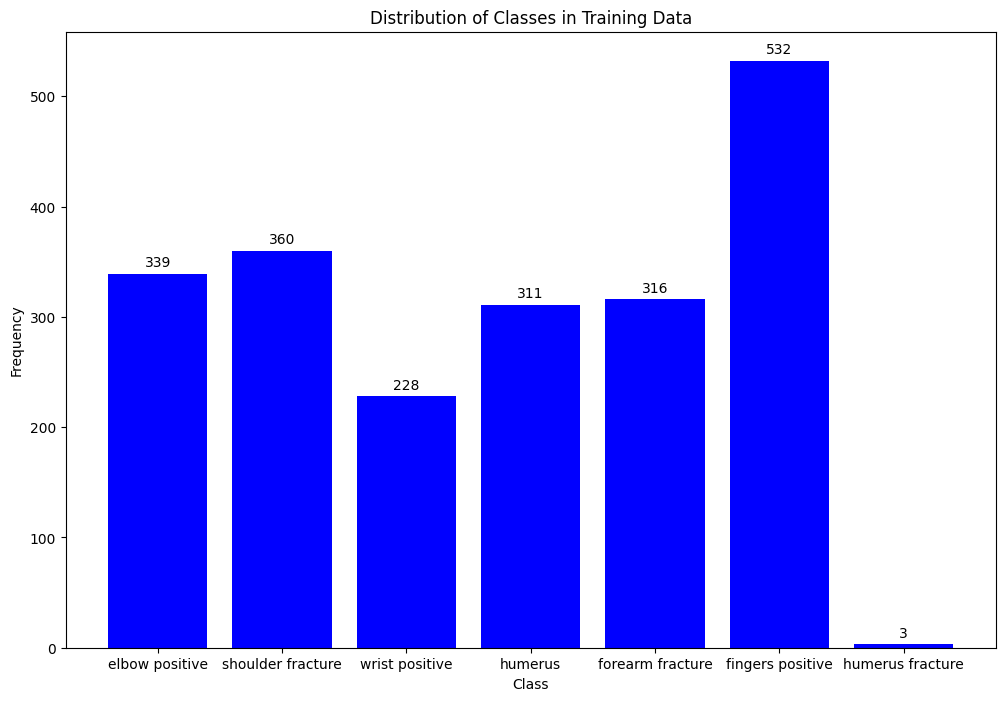

In [29]:
# Count the frequency of each class id from your validation data
class_distribution = Counter(all_class_ids_training)

# Convert counts to lists for plotting and map numeric class IDs to class names
classes = list(class_distribution.keys())
counts = list(class_distribution.values())
mapped_class_names = [class_map.get(cid, cid) for cid in classes]

# Create a figure and plot the distribution
plt.figure(figsize=(12, 8))
bars = plt.bar(mapped_class_names, counts, color='blue')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of Classes in Training Data')

# Annotate each bar with its frequency number
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # offset by 3 points above the bar
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.show()

In [30]:
# Define the dataset path
dataset_path = '/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection/dataset/bonefractureyolo'

# Construct the path to your YAML file and load it
yaml_file_path = os.path.join(dataset_path, 'data.yaml')
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)

# Extract class names from YAML; assumes keys "nc" and "names" exist
class_names_list = config['names']

# Create a mapping from class id (as string) to class name
class_map = {str(i): name for i, name in enumerate(class_names_list)}

# Construct paths for validation images and labels
validation_images_dir = os.path.join(dataset_path, 'valid/images')
validation_labels_dir = os.path.join(dataset_path, 'valid/labels')

# Get sorted lists of image and label files
validation_image_files = sorted([f for f in os.listdir(validation_images_dir) if f.endswith('.jpg')])
validation_label_files = sorted([f for f in os.listdir(validation_labels_dir) if f.endswith('.txt')])

# Initialize a list to store all class ids from the label files
all_class_ids_validation = []

# Loop through each label file and extract class ids
for label_file in validation_label_files:
    label_path = os.path.join(validation_labels_dir, label_file)
    with open(label_path, 'r') as f:
        for line in f:
            if line.strip():  # ensure the line is not empty
                parts = line.strip().split()
                class_id = parts[0]  # Assumes the first value is the class id
                all_class_ids_validation.append(class_id)

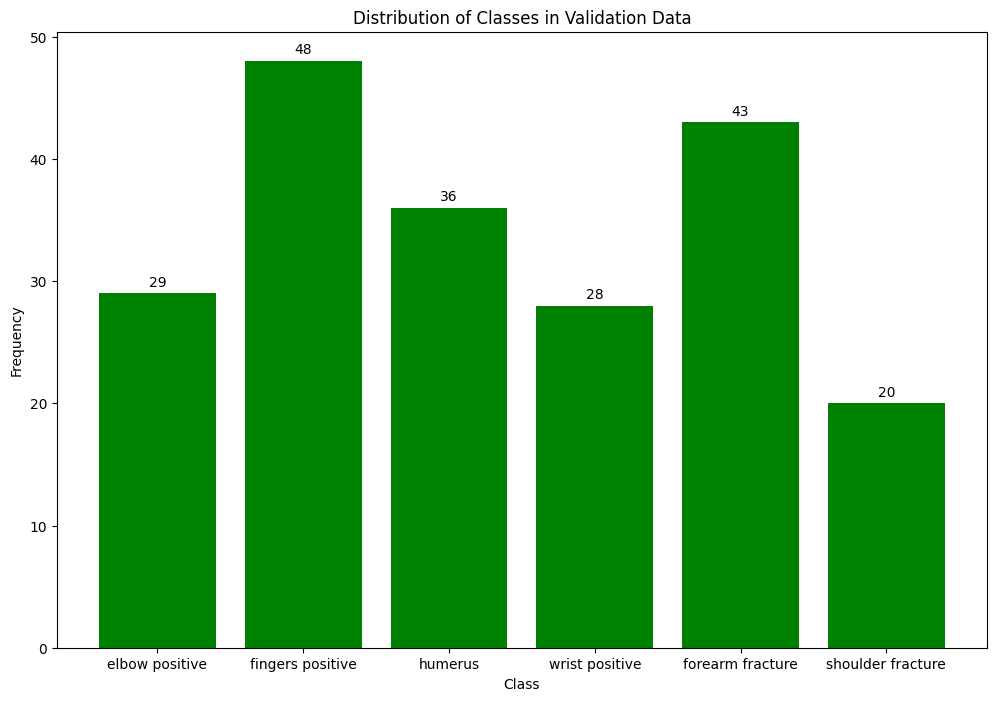

In [33]:
# Count the frequency of each class id from your validation data
class_distribution = Counter(all_class_ids_validation)

# Convert counts to lists for plotting and map numeric class IDs to class names
classes = list(class_distribution.keys())
counts = list(class_distribution.values())
mapped_class_names = [class_map.get(cid, cid) for cid in classes]

# Create a figure and plot the distribution
plt.figure(figsize=(12, 8))
bars = plt.bar(mapped_class_names, counts, color='green')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of Classes in Validation Data')

# Annotate each bar with its frequency number
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # offset by 3 points above the bar
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.show()


In [32]:
# Define the dataset path
dataset_path = '/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection/dataset/bonefractureyolo'

# Construct the path to your YAML file and load it
yaml_file_path = os.path.join(dataset_path, 'data.yaml')
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)

# Extract class names from YAML; assumes keys "nc" and "names" exist
class_names_list = config['names']

# Create a mapping from class id (as string) to class name
class_map = {str(i): name for i, name in enumerate(class_names_list)}

# Construct paths for validation images and labels
test_images_dir = os.path.join(dataset_path, 'test/images')
test_labels_dir = os.path.join(dataset_path, 'test/labels')

# Get sorted lists of image and label files
test_image_files = sorted([f for f in os.listdir(test_images_dir) if f.endswith('.jpg')])
test_label_files = sorted([f for f in os.listdir(test_labels_dir) if f.endswith('.txt')])

# Initialize a list to store all class ids from the label files
all_class_ids_test = []

# Loop through each label file and extract class ids
for label_file in test_label_files:
    label_path = os.path.join(test_labels_dir, label_file)
    with open(label_path, 'r') as f:
        for line in f:
            if line.strip():  # ensure the line is not empty
                parts = line.strip().split()
                class_id = parts[0]  # Assumes the first value is the class id
                all_class_ids_test.append(class_id)

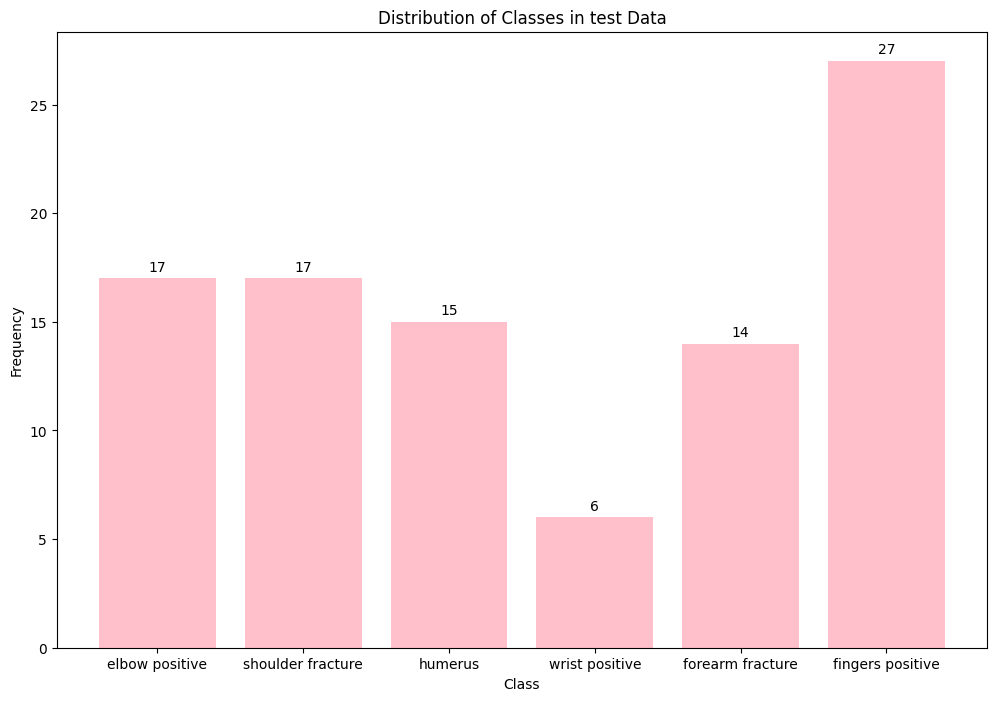

In [34]:
# Count the frequency of each class id from your test data
class_distribution = Counter(all_class_ids_test)

# Convert counts to lists for plotting and map numeric class IDs to class names
classes = list(class_distribution.keys())
counts = list(class_distribution.values())
mapped_class_names = [class_map.get(cid, cid) for cid in classes]

# Create a figure and plot the distribution
plt.figure(figsize=(12, 8))
bars = plt.bar(mapped_class_names, counts, color='pink')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of Classes in test Data')

# Annotate each bar with its frequency number
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # offset by 3 points above the bar
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.show()

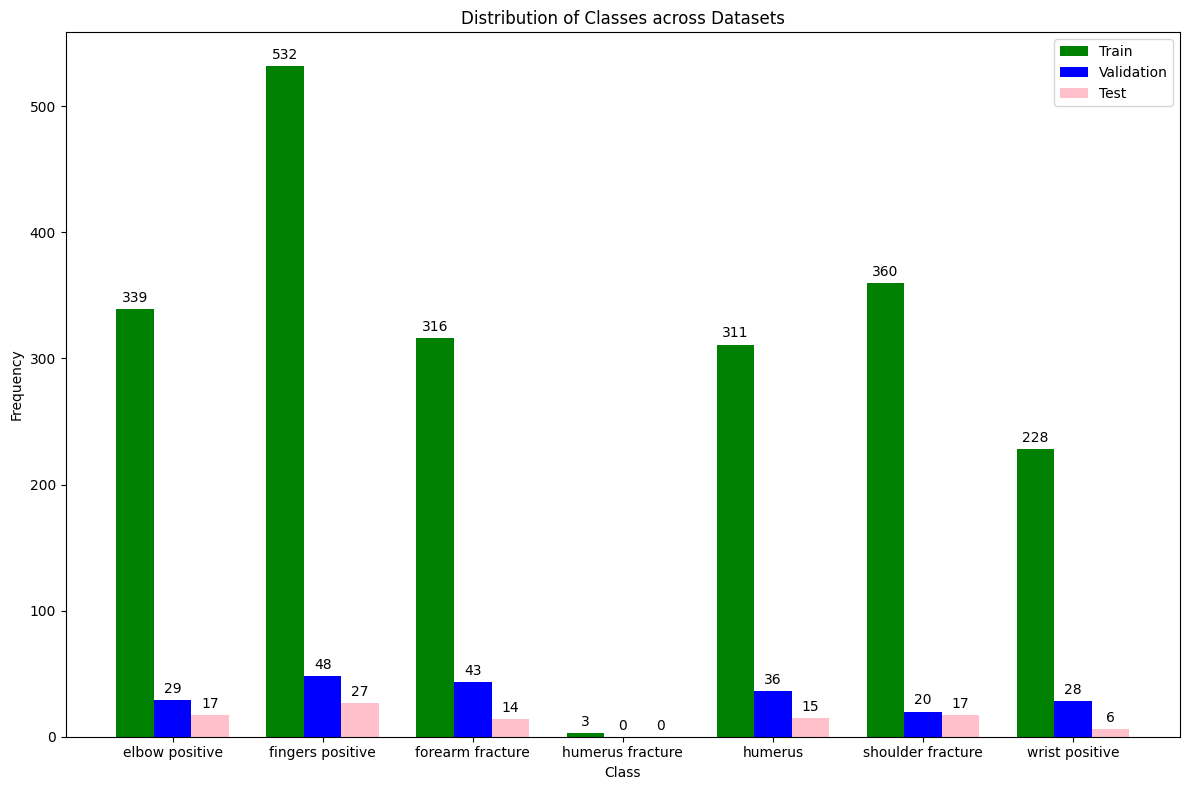

In [39]:
# Create a mapping from class id (as string) to class name (assumes order is maintained)
class_map = {str(i): name for i, name in enumerate(config['names'])}


# train_distribution = Counter(all_class_ids_train)
# val_distribution = Counter(all_class_ids_validation)
# test_distribution = Counter(all_class_ids_test)

# For the grouped bar chart, we'll use the fixed set of class IDs based on the YAML file.
all_class_ids = [str(i) for i in range(len(config['names']))]
mapped_class_names = [class_map[cid] for cid in all_class_ids]

# Count frequency for each subset (if a class is missing, count as 0)
train_distribution = Counter(all_class_ids_training)
val_distribution = Counter(all_class_ids_validation)
test_distribution = Counter(all_class_ids_test)

train_counts = [train_distribution.get(cid, 0) for cid in all_class_ids]
val_counts   = [val_distribution.get(cid, 0) for cid in all_class_ids]
test_counts  = [test_distribution.get(cid, 0) for cid in all_class_ids]

# ====== Plotting ======
x = np.arange(len(all_class_ids))  # the label locations
width = 0.25  # the width of the bars

plt.figure(figsize=(12,8))

# Create the grouped bars
bars_train = plt.bar(x - width, train_counts, width, label='Train', color='green')
bars_val   = plt.bar(x, val_counts, width, label='Validation', color='blue')
bars_test  = plt.bar(x + width, test_counts, width, label='Test', color='pink')

plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of Classes across Datasets')
plt.xticks(x, mapped_class_names)
plt.legend()

# Annotate each bar with its frequency number
for bars in [bars_train, bars_val, bars_test]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # offset above the bar
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.tight_layout()
plt.show()
